<a href="https://colab.research.google.com/github/Dheepthi-Reddy/DheepthiReddy_INFO5731_Fall2024/blob/main/Vangeti_Dheepthi_Exercise_04_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 In-class Exercise 4**

**This exercise will provide a valuable learning experience in working with text data and extracting features using various topic modeling algorithms. Key concepts such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA), lda2vec, and BERTopic.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## Question 1 (10 Points)

**Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
# Write your code here

!pip install

# Import necessary packages
import re                   # Regular expressions for text preprocessing
import numpy as np          # Numpy for numerical operations
import pandas as pd         # pandas for data manipulation and analysis
from pprint import pprint   # Pretty-printing for better understanding of output

# Gensim
import gensim                               # genism for topic modeling
import gensim.corpora as corpora            # for creating dictionaries and corpus for LDA
from gensim.utils import simple_preprocess  # simple_preprocess for text preprocessing
from gensim.models import CoherenceModel    # to calculating coherence scores of topics


# NLTK Stop words
import nltk                         # Natural Language Toolkit for text processing
nltk.download('stopwords')          # Download stopwords for filtering out common words
from nltk.corpus import stopwords   # Import stopwords list



# spacy for lemmatization
import spacy                      # spacy for advanced NLP tasks
import matplotlib.pyplot as plt   # matplotlib for plotting


# Load spacy model
!python3 -m spacy download en_core_web_sm                      # to download the small English model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])  # to load the model without parser and named entity recognizer for efficiency

ERROR: You must give at least one requirement to install (see "pip help install")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 83.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# loading the dataset
df = pd.read_csv('Reviews.csv')           # reading the CSV file into a DataFrame
review_data = df['Review Text'].values.tolist()  # taking 'Review Text' column as a list

# Text preprocessing
def preprocessData(review_data):
    review_data = [re.sub('\S*@\S*\s?', '', sent) for sent in review_data]    # to remove emails, newlines, and single quotes from each review
    review_data = [re.sub('\s+', ' ', sent) for sent in review_data]          # to replace multiple spaces with a single space
    review_data = [re.sub("\'", "", sent) for sent in review_data]            # to remove single quotes
    return review_data                                                 # return the cleaned data

review_data = preprocessData(review_data)  # preprocessing

# Tokenize words and clean-up text
def sentToWords(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=True)     # Tokenizing sentences into words and removing punctuation

dataWords = list(sentToWords(review_data))  # Converting all sentences to a list of tokenized words

# building bigram and trigram models
bigram = gensim.models.Phrases(dataWords, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[dataWords], threshold=100)
bigram_model = gensim.models.phrases.Phraser(bigram)                      # creating a Phraser for bigrams
trigram_model = gensim.models.phrases.Phraser(trigram)                    # creating a Phraser for trigrams

stop_words = stopwords.words('english')                       # to get English stop words from NLTK
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])    # adding additional common stop words

# function to remove stopwords
def removeStopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# function to make bigrams
def makeBigrams(texts):
    return [bigram_model[doc] for doc in texts]

# function to lemmatize
def makeTrigrams(texts):
    return [trigram_model[bigram_model[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []                    # initializing an empty list for lemmatized texts
    for sent in texts:
        doc = nlp(" ".join(sent))     # joining words into a single string for lemmatization
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])      # appending lemmatized tokens of allowed parts of speech to the output list
    return texts_out

# Run preprocessing functions
dataWithoutStopwords = removeStopwords(dataWords)                                                     # remove stop words from the tokenized data
dataBigrams = makeBigrams(dataWithoutStopwords)                                                 # Create bigrams from the data
lemmatizedData = lemmatization(dataBigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])   # lemmatizing the data

# creating Dictionary and Corpus
id2word = corpora.Dictionary(lemmatizedData)       # creating a dictionary mapping from word IDs to words
texts = lemmatizedData                             # storing the preprocessed texts
corpus = [id2word.doc2bow(text) for text in texts]  # create a bag-of-words representation for the corpus

# function to compute coherence score and select optimal number of topics
def coherenceValues(dictionary, corpus, texts, limit, start=2, step=3):
    coherenceValues = []                                         # initializing a list to store coherence values
    modelList = []                                               # Initializing a list to store the LDA models
    for num_topics in range(start, limit, step):
        # train LDA model with specified number of topics
        ldaModel = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics,
                                       random_state=100,          # seed for reproducibility
                                       update_every=1,
                                       chunksize=100,
                                       passes=10,                 # number of passes through the corpus
                                       alpha='auto',              # setting alpha to 'auto' for better topic estimation
                                       per_word_topics=True)      # tracking per-word topic distributions
        modelList.append(ldaModel)                                  # appending the model to the list
        # calculating coherence score for the current model
        coherencemodel = CoherenceModel(model=ldaModel, texts=texts, dictionary=dictionary, coherence='c_v')
        coherenceValues.append(coherencemodel.get_coherence())  # appending the coherence score to the list
    return modelList, coherenceValues                          # returning the models and their coherence values

# setting range for number of topics to try and compute coherence
start, limit, step = 2, 20, 2
modelList, coherenceValues = coherenceValues(dictionary=id2word, corpus=corpus, texts=lemmatizedData, start=start, limit=limit, step=step)
print("\n")

# print coherence scores
for m, cv in zip(range(start, limit, step), coherenceValues):
    print(f"Number of Topics = {m}, Coherence Score = {cv}")  # print number of topics and corresponding coherence score



Number of Topics = 2, Coherence Score = 0.34945775303982823
Number of Topics = 4, Coherence Score = 0.2562680705946782
Number of Topics = 6, Coherence Score = 0.29001258903450994
Number of Topics = 8, Coherence Score = 0.2928804298452084
Number of Topics = 10, Coherence Score = 0.27975526229941367
Number of Topics = 12, Coherence Score = 0.3441898693083676
Number of Topics = 14, Coherence Score = 0.3252234926273256
Number of Topics = 16, Coherence Score = 0.30226436915461535
Number of Topics = 18, Coherence Score = 0.3338686639938955



Optimal number of topics: 2

[(0,
  '0.024*"movie" + 0.018*"film" + 0.012*"deadpool" + 0.012*"really" + '
  '0.010*"make" + 0.010*"feel" + 0.010*"fun" + 0.010*"go" + 0.009*"cameo" + '
  '0.009*"story"'),
 (1,
  '0.025*"movie" + 0.019*"film" + 0.013*"make" + 0.011*"deadpool" + 0.009*"go" '
  '+ 0.009*"really" + 0.009*"want" + 0.009*"scene" + 0.009*"fun" + '
  '0.008*"cameo"')]


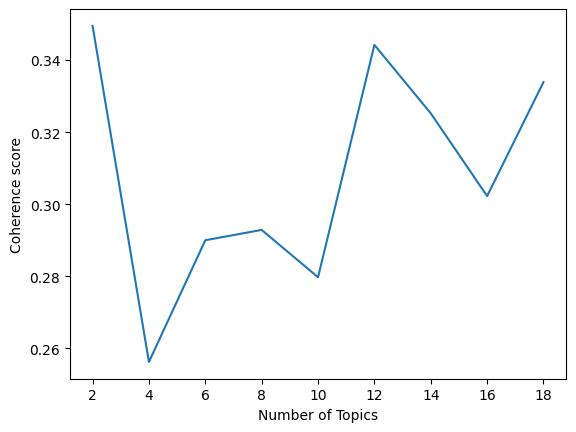

In [ ]:
# select the model with highest coherence
optimalIndex = coherenceValues.index(max(coherenceValues))         # finding the index of the maximum coherence score
optimalModel = modelList[optimalIndex]                             # retrieving the model corresponding to the highest coherence score
print(f"\nOptimal number of topics: {start + optimalIndex * step}\n")  # calculating and printing the optimal number of topics

pprint(optimalModel.print_topics())  # printing the topics from the optimal model

# plotting coherence score for different numbers of topics
x = range(start, limit, step)  # range object for the x-axis
plt.plot(x, coherenceValues)  # plotting the coherence scores against the number of topics
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.show()

## Question 2 (10 Points)

**Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [ ]:
# Write your code here

import pandas as pd                                     # For data manipulation and analysis
import os                                               # For interacting with the operating system (e.g., file paths)
from gensim import corpora                              # To create a dictionary and corpus for LSI
from gensim.models import LsiModel                      # To build the LSI model
from nltk.tokenize import RegexpTokenizer               # For tokenizing text
from nltk.corpus import stopwords                       # For removing stop words from text
from nltk.stem.porter import PorterStemmer              # For stemming words
from gensim.models.coherencemodel import CoherenceModel # To compute coherence score of topics
import matplotlib.pyplot as plt                         # For plotting graphs and visualizations

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def loadData(csvFile):
    df = pd.read_csv(csvFile)                    # reading CSV file
    data = df['Review Text'].tolist()
    return data                           # returning the list of comments

# function to preprocess Data
def preprocessData(doc_set):
    tokenizer = RegexpTokenizer(r'\w+')         # initializing a tokenizer to split text into words
    en_stop = set(stopwords.words('english'))   # setting of English stop words to be removed
    p_stemmer = PorterStemmer()                 # initializing the Porter Stemmer for stemming words
    texts = []                                  # list to hold cleaned texts

    for doc in doc_set:
        raw = doc.lower()                                                # converting the document to lowercase
        tokens = tokenizer.tokenize(raw)                                 # tokenizing the document
        stopped_tokens = [i for i in tokens if not i in en_stop]         # removing stop words from the tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]     # stemming remaining tokens
        texts.append(stemmed_tokens)                                     # adding cleaned tokens to the list

    return texts

# function to prepare Corpus
def prepareCorpus(doc_clean):
    dictionary = corpora.Dictionary(doc_clean)                            # creating a dictionary mapping from word IDs to words
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]      # creating a document-term matrix for the cleaned documents
    return dictionary, doc_term_matrix

# function to create an LSA model using Gensim
def gensimLsaModel(doc_clean, number_of_topics):
    dictionary, doc_term_matrix = prepareCorpus(doc_clean)                                   # preparing the corpus for the LSA model
    lsa_model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word=dictionary)    # creating the LSA model with the specified number of topics
    return lsa_model, dictionary, doc_term_matrix

# function to compute Coherence Values
def coherenceValues(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=2):
    coherence_values = []  # list to store coherence scores
    model_list = []        # list to store LSA models
    for num_topics in range(start, stop, step):                           # for loop to iterate over a range of topic numbers
        model, _, _ = gensimLsaModel(doc_clean, num_topics)      # creating LSA model for the current number of topics
        model_list.append(model)                                          # appending the model to the list
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v') # coherence score for the current model
        coherence_values.append(coherencemodel.get_coherence())  # Append the score to the list

    return model_list, coherence_values  # Return models and coherence values

csvFile = 'Reviews.csv'                        # specifying the path to the dataset
data = loadData(csvFile)                  # loading the comments from the dataset
cleanComments = preprocessData(data)  # preprocessing the comments

dictionary, doc_term_matrix = prepareCorpus(cleanComments)  # prepare the corpus
start, stop, step = 2, 20, 1                                  # set the range for topic numbers

modelList, coherenceValues = coherenceValues(dictionary, doc_term_matrix, cleanComments, stop, start, step)   # coherence scores

print("\n")

for i, score in enumerate(coherenceValues):
    print(f"Number of Topics = {start + i * step}, Coherence Score = {score}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: `scipy.sparse.sparsetools.csc_matvecs` is deprecated along with the `scipy.sparse.sparsetools` namespace. `scipy.sparse.sparsetools.csc_matvecs` will be removed in SciPy 1.14.0, and the `scipy.sparse.sparsetools` namespace will be removed in SciPy 2.0.0.
  sparsetools.csc_matvecs(
/usr/local/lib/python3.10/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: `scipy.sparse.sparsetools.csc_matvecs` is deprecated along with the `scipy.sparse.sparsetools` namespace. `scipy.sparse.sparsetools.csc_matvecs` will be removed in SciPy 1.14.0, and



Number of Topics = 2, Coherence Score = 0.2659612518000024
Number of Topics = 3, Coherence Score = 0.37764087838884186
Number of Topics = 4, Coherence Score = 0.3564158297091748
Number of Topics = 5, Coherence Score = 0.42264416286957374
Number of Topics = 6, Coherence Score = 0.40895233411738935
Number of Topics = 7, Coherence Score = 0.39630075403278686
Number of Topics = 8, Coherence Score = 0.437945896381677
Number of Topics = 9, Coherence Score = 0.37194025611024734
Number of Topics = 10, Coherence Score = 0.37327503693764247
Number of Topics = 11, Coherence Score = 0.4067234250153547
Number of Topics = 12, Coherence Score = 0.3982692396494912
Number of Topics = 13, Coherence Score = 0.3467643227537502
Number of Topics = 14, Coherence Score = 0.34119742558227245
Number of Topics = 15, Coherence Score = 0.3372208306697327
Number of Topics = 16, Coherence Score = 0.3708519359092006
Number of Topics = 17, Coherence Score = 0.36060177082461886
Number of Topics = 18, Coherence Score 

In [ ]:
# identifying the optimal number of topics based on coherence scores
optimalIndex = coherenceValues.index(max(coherenceValues))   # finding the index of the maximum coherence score
optimalNumTopics = start + optimalIndex * step               # calculating the optimal number of topics
print(f"\nOptimal number of topics: {optimalNumTopics}\n")

final_model, _, _ = gensimLsaModel(cleanComments, optimalNumTopics)  # creating final LSA model using the optimal number of topics

topics = final_model.print_topics(num_topics=optimalNumTopics, num_words=10)
for topic in topics:
    print(f"\nTopic {topic[0]}: {topic[1]}")


Optimal number of topics: 8


Topic 0: 0.324*"movi" + 0.277*"film" + 0.268*"deadpool" + 0.228*"like" + 0.221*"one" + 0.205*"cameo" + 0.196*"realli" + 0.183*"wolverin" + 0.176*"mcu" + 0.160*"much"

Topic 1: 0.313*"movi" + -0.184*"cameo" + -0.173*"much" + 0.161*"wolverin" + 0.137*"deadpool" + 0.135*"realli" + 0.121*"stori" + 0.119*"marvel" + -0.119*"everyon" + -0.118*"mcu"

Topic 2: 0.359*"film" + -0.306*"movi" + -0.202*"fun" + 0.200*"wolverin" + 0.182*"deadpool" + -0.161*"make" + -0.143*"mcu" + -0.141*"sure" + -0.138*"beyond" + -0.130*"even"

Topic 3: -0.216*"deadpool" + 0.197*"pull" + 0.185*"fight" + 0.146*"point" + 0.126*"scene" + 0.117*"second" + 0.112*"watch" + 0.112*"film" + 0.110*"fan" + 0.110*"know"

Topic 4: -0.295*"film" + 0.196*"movi" + 0.180*"like" + -0.162*"best" + -0.151*"marvel" + -0.150*"make" + -0.146*"deadpool" + 0.142*"realli" + -0.140*"2" + -0.138*"superhero"

Topic 5: -0.207*"superhero" + -0.188*"best" + -0.174*"marvel" + 0.166*"fun" + 0.161*"film" + -0.155*"new" + 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: `scipy.sparse.sparsetools.csc_matvecs` is deprecated along with the `scipy.sparse.sparsetools` namespace. `scipy.sparse.sparsetools.csc_matvecs` will be removed in SciPy 1.14.0, and the `scipy.sparse.sparsetools` namespace will be removed in SciPy 2.0.0.
  sparsetools.csc_matvecs(


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


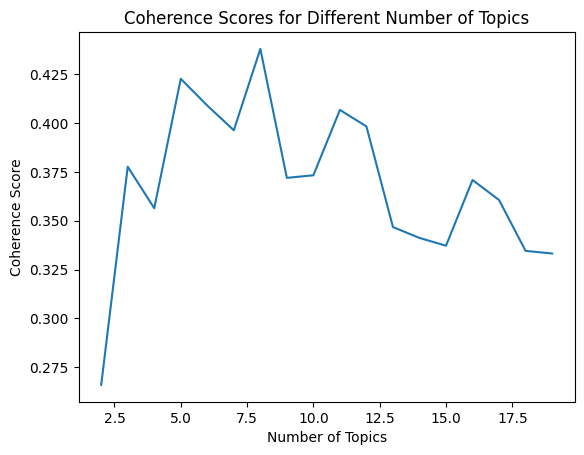

In [ ]:
# function to plot coherence scores against the number of topics
def plot_graph(start, stop, step, coherence_values):
    x = range(start, stop, step)
    plt.plot(x, coherenceValues)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores for Different Number of Topics")
    plt.show()

# plotting coherence score values
plot_graph(start, stop, step, coherenceValues)

## Question 3 (10 points):
**Generate K topics by using lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

In [ ]:
# Write your code here

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Question 4 (10 points):
**Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [ ]:
# Write your code here

# Install the BERTopic library
!pip install bertopic

# Importing necessary libraries
from bertopic import BERTopic                           # BERTopic for topic modeling
import pandas as pd                                     # pandas for data manipulation
from nltk.tokenize import RegexpTokenizer               # RegexpTokenizer for text tokenization
from nltk.corpus import stopwords                       # stopwords from NLTK to filter out common words
import nltk                                             # NLTK for natural language processing tasks
from gensim.corpora.dictionary import Dictionary        # Dictionary from Gensim for creating a mapping of words to IDs
from gensim.models.coherencemodel import CoherenceModel # CoherenceModel for evaluating the quality of topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.3 MB/s eta 0:00:00


In [ ]:
# Loading dataset from a CSV file
review_data = pd.read_csv("Reviews.csv")                          # Read the CSV file containing reviews into a DataFrame
docs = review_data['Review Text'].tolist()                        # converting the 'Review Text' to a list

# initializing and fitting the BERTopic model
bertModel = BERTopic(language="english",                 # BERTopic model specifying the language
                        calculate_probabilities=True,      # enabling probability calculations for topics
                        verbose=True)                      # enabling verbose output for progress tracking
topics, probs = bertModel.fit_transform(docs)            # fitting the model on the documents and transforming them to topic space
topicInfo = bertModel.get_topic_info()                  # retrieving information about the identified topics

for i in range(7):
    print(f"Topic {i}: {bertModel.get_topic(i)}\n")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2024-11-01 18:23:49,295 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

2024-11-01 18:24:04,873 - BERTopic - Embedding - Completed ✓
2024-11-01 18:24:04,877 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-01 18:24:28,214 - BERTopic - Dimensionality - Completed ✓
2024-11-01 18:24:28,223 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-01 18:24:28,278 - BERTopic - Cluster - Completed ✓
2024-11-01 18:24:28,314 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-01 18:24:28,415 - BERTopic - Representation - Completed ✓


Topic 0: [('the', 0.1118039507242354), ('and', 0.0706458508564263), ('to', 0.05745278774154084), ('it', 0.056425667768804075), ('of', 0.05632255550298398), ('but', 0.04765186643026053), ('movie', 0.04765186643026053), ('for', 0.0472832037136799), ('is', 0.046515573201921526), ('was', 0.04605318973916766)]

Topic 1: [('the', 0.11439603705549992), ('and', 0.08850012669667667), ('to', 0.06666502612811748), ('of', 0.05602500237957199), ('it', 0.0541960543379396), ('is', 0.04840067801063098), ('was', 0.04595793660434242), ('that', 0.0447999405427176), ('its', 0.042062770534793605), ('deadpool', 0.04050421744873723)]

Topic 2: False

Topic 3: False

Topic 4: False

Topic 5: False

Topic 6: False



In [ ]:
topics = bertModel.get_topics()     # to retrieve the topics generated by the BERTopic model

wordsPerTopic = []              # to initialize a list to hold the top words for each topic
for topic, words in topics.items():   # for loop to iterate through each topic and its associated words
    if topic != -1:                   # excluding the -1 topic which is used for outliers
        topWords = [word for word, _ in words]   # extracting only the words from the topic and store them in a list
        wordsPerTopic.append(topWords)     # adding the top words to the list

documents = review_data['Review Text'].astype(str).tolist()
tokenizer = RegexpTokenizer(r'\w+')   # Tokenizer to split the text into words
stopWords = set(stopwords.words('english'))  # NLTK's list of English stopwords

# preprocessing documents: tokenize and remove stopwords
processedDocs = [[word for word in tokenizer.tokenize(doc.lower()) if word not in stopWords] for doc in documents]
dictionary = Dictionary(processedDocs)                         # creating a Gensim dictionary from the processed documents to map words to IDs
corpus = [dictionary.doc2bow(doc) for doc in processedDocs]    # converting the processed documents into a bag-of-words format using the dictionary

# to calculate the coherence score for the identified topics
coherenceModel = CoherenceModel(topics=wordsPerTopic, texts=processedDocs, dictionary=dictionary, coherence='c_v')
coherenceScore = coherenceModel.get_coherence()           # to get the coherence score value from the model
print(f"Coherence Score: {coherenceScore}")

# determining the number of topics
numberOfTopics = topicInfo.shape[0] - (1 if any(topicInfo['Topic'] == -1) else 0)
print(f"Number of Topics (K): {numberOfTopics}")

print("\nTopic Summaries:")
for i in range(numberOfTopics):
    topWords = bertModel.get_topic(i)      # retrieving top n words for each topic; adjust n as needed
    if topWords is not None:                 # checking if the topic exists
        topicSummary = ", ".join([word for word, score in topWords])
        print(f"Topic {i}: {topicSummary}\n")
    else:
        break

Coherence Score: 1.0
Number of Topics (K): 2

Topic Summaries:
Topic 0: the, and, to, it, of, but, movie, for, is, was

Topic 1: the, and, to, of, it, is, was, that, its, deadpool



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Question 3 (Alternative) - (10 points)**

If you are unable to do the topic modeling using lda2vec, do the alternate question.

Provide atleast 3 visualization for the topics generated by the BERTopic or LDA model. Explain each of the visualization in detail.

In [ ]:
!pip install --upgrade pyLDAvis gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 20.8 MB/s eta 0:00:00


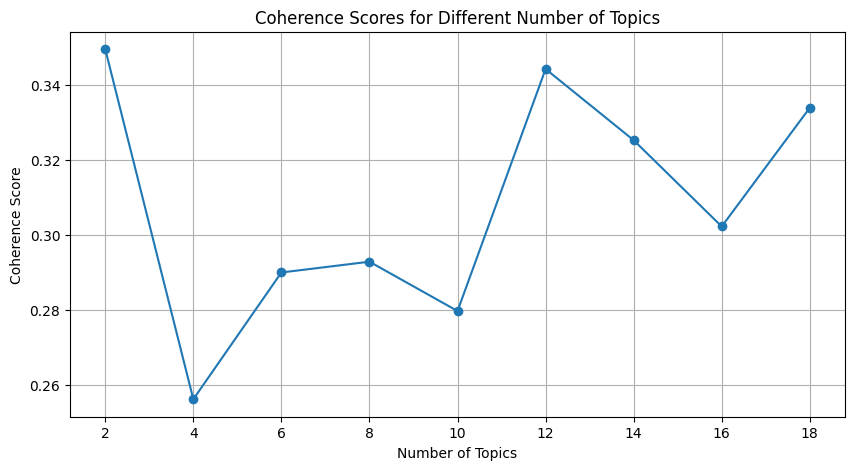

'\nThis plot visualizes the coherence scores of LDA models with varying numbers of topics. \nx-axis represents the number of topics,  \ny-axis shows the corresponding coherence scores. \nA higher coherence score means that the topics created by the model are clear and make more sense together.\nwe can see that the point where the coherence scores are highest. This helps in deciding the optimal number of topics for the LDA model.\nIn this case, the point with the highest score would be selected for further analysis.\n\n'

In [ ]:
# Write your code here

import matplotlib.pyplot as plt

# 1. Coherence Score Bar Plot

plt.figure(figsize=(10, 5))                                             # setting the size to the figure
plt.plot(range(start, limit, step), coherenceValues, marker='o')        # plotting the coherence scores with the number of topics, using 'o' markers for data points
plt.title('Coherence Scores for Different Number of Topics')            # title of the plot
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(range(start, limit, step))                                   # x-ticks to display the number of topics tested
plt.grid()
plt.show()

# Then Explain the visualization
'''
This plot visualizes the coherence scores of LDA models with varying numbers of topics.
x-axis represents the number of topics,
y-axis shows the corresponding coherence scores.
A higher coherence score means that the topics created by the model are clear and make more sense together.
we can see that the point where the coherence scores are highest. This helps in deciding the optimal number of topics for the LDA model.
In this case, the point with the highest score would be selected for further analysis.

'''
# Repeat for the other 2 visualizations as well.

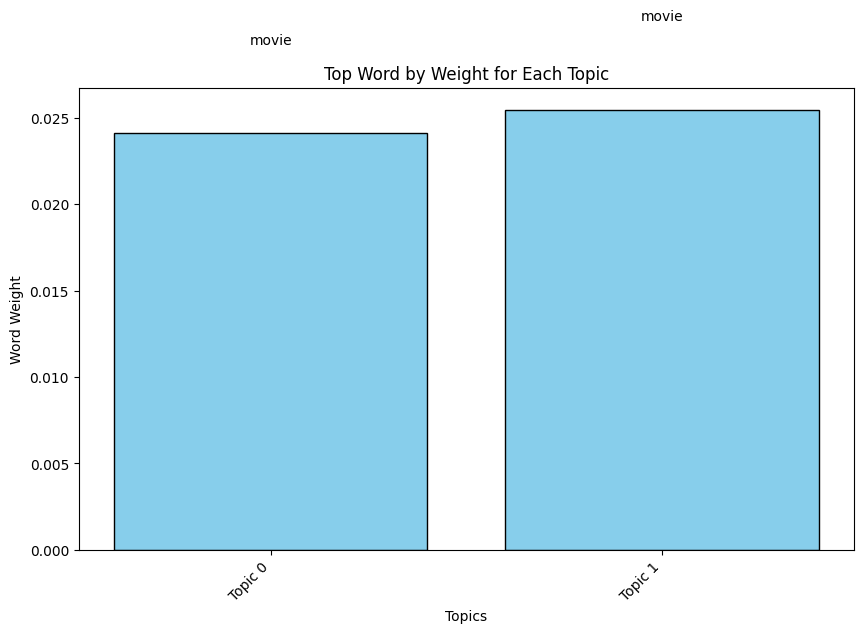

In [ ]:
# 2. Top Word by Weight for Each Topic Bar Chart

# Defining lists to store the top word and its weight for each topic
topWords = []
topWeights = []
topicLabels = []

# Looping through each topic to get the top word and its weight
for topic_num, topic in optimalModel.show_topics(num_topics=14, num_words=1, formatted=False):  # Iterating over topics
    topWords.append(topic[0][0])      # getting the top word for each topic
    topWeights.append(topic[0][1])    #extracting the weight of the top word
    topicLabels.append(f"Topic {topic_num}")  # Creating labels for topics

# Plotting a bar chart with the top word from each topic
plt.figure(figsize=(10, 6))
plt.bar(topicLabels, topWeights, color='skyblue', edgecolor='black')  # Creating a bar chart
plt.xticks(rotation=45, ha='right')             #rotating x-axis labels
plt.title("Top Word by Weight for Each Topic")  # title
plt.xlabel("Topics")
plt.ylabel("Word Weight")

# Annotating bars with top words
for i in range(len(topWords)):
    plt.text(i, topWeights[i] + 0.005, topWords[i], ha='center', va='bottom', fontsize=10, color='black')  #adds text annotation above each bar


plt.show()

# Then Explain the visualization

'''
This plot shows the top word by weight for each topic generated by the LDA model. T
he x-axis denotes the various topics, while the y-axis represents the weight of the top word for each topic, representing its importance.
Each bar corresponds to the significance of the most relevant word associated with its respective topic, with taller bars reflecting a stronger relationship.
The bars are also annotated with the top words, increasing clarity regarding the central themes of each topic.
This visualization effectively highlights the key terms that define the topics, giving a better understanding of the themes captured by the model.
'''

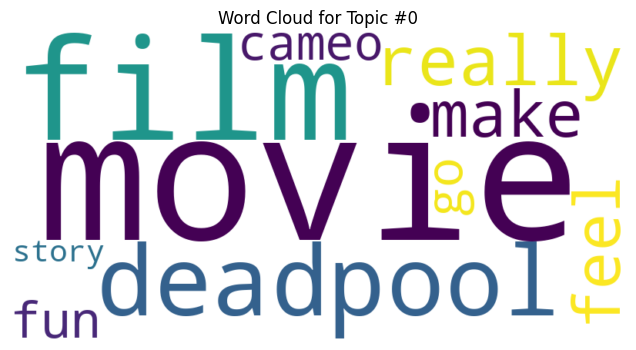

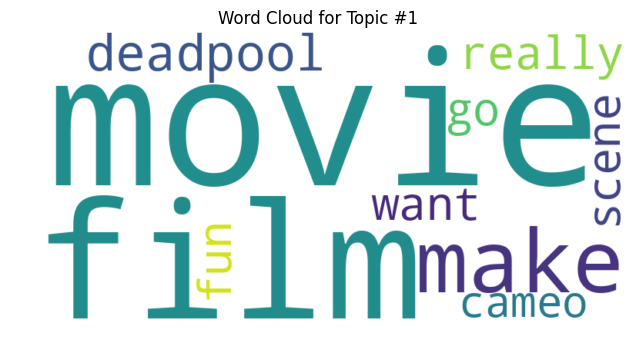

'\nExplanation:\n\n- In this visualization, a word cloud is generated for each topic from the LDA model.\nEach word cloud represents the most significant words for a specific topic, with the size\nof each word reflecting its importance (weight) in that topic. Larger words indicate higher\nrelevance, while smaller words have a lesser but still notable contribution to the topic.\n\nFor example:\n- Topic #0: The output likely revolves around themes related to music or performance\n(as indicated by "song," "lyric," and "dance") and creative or expressive actions\n(as suggested by "make," "give," and "love"). This word cloud, therefore, helps to quickly\nidentify what Topic #0 might focus on, especially if we\'re analyzing multiple topics at once.\nIt provides a straightforward way to visually grasp the key ideas of each topic based on word prominence.\n\n'

In [ ]:
# Write your code here

# 3. Highlighting Dominant Words in Each Topic with Topic-Wise Word Clouds

from wordcloud import WordCloud  # Importing WordCloud class for visualization

# Generating and plotting word clouds for each topic
for topic_num, topic in optimalModel.show_topics(num_topics=14, formatted=False):  # Looping through topics
    plt.figure(figsize=(8, 4))  # Creating a new figure with specified size
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(topic))  # Generating word cloud from topic frequencies
    plt.imshow(wordcloud, interpolation='bilinear')  # Displaying the word cloud image
    plt.axis("off")  # Hiding axes for a cleaner look
    plt.title(f"Word Cloud for Topic #{topic_num}")  # title of the plot
    plt.show()


# Then Explain the visualization

'''
This plot is for creating word clouds for each topic identified by the LDA model.
It visualizes the most important words associated with each topic, with larger words indicating greater importance.
Each word cloud is displayed in a separate figure, allowing for easy comparison of topics.
Helping in understanding the key themes represented by the topics.

'''


In [ ]:
# 3. pyLDAvis Visualization

# Explain the visualization
'''
The pyLDAvis visualization is an interactive interface for exploring the topics generated by the models.
This displays a two-dimensional representation of the topics, where each circle represents a topic,
and the size of the circle shows how important is that topic.
The distance between circles shows the similarity between topics: if the circles are closer then the topics share more common words.
The right panel with horizontal bar chart shows the most significant words for the selected topic.
This interactive visualization helps in the understanding of relationships among topics and their key terms, making it easier to interpret the overall findings of the topic modeling process.
'''

In [ ]:
import pyLDAvis.gensim

# preparing the LDA model visualization using the optimal model, the corpus, and the dictionary
vis = pyLDAvis.gensim.prepare(optimalModel, corpus, id2word)
pyLDAvis.display(vis)

## Extra Question (5 Points)

**Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.**

**This question will compensate for any points deducted in this exercise. Maximum marks for the exercise is 40 points.**

In [ ]:
# Write your code here

'''
Latent Dirichlet Allocation:

It is a probabilistic model which assumes documents are a mixture of topics, with each topic represented by a distribution over words.
For the dataset I used LDA returned two distinct topics:

Topic 0 : "movie," "film," and "Deadpool," focuses on the specific film.
Topic 1 : with similar terms while including words like "make" and "scene," showing the broader context within the film narrative.

Optimal Number of Topics: 2,  Coherence Score: 0.349.

Though LDA successfully identifies coherent topics, it restricts to just two topics, making it less effective for analysis.

Latent Semantic Analysis:

It uses Singular Value Decomposition (SVD) to reduce the dimensionality of the document-term matrix, for the identification of latent structures in the data.

Topic 0 : "movie," "film," and "Deadpool," emphasizing character dynamics and viewer engagement.
Topic 1 : shows diverse themes related to superhero narratives, character development, and cinematic experiences.

Optimal Number of Topics: 8, Coherence Score: 0.437.

The coherence score of 0.437 is higher than that of LDA, giving more effective representation of themes.
In this the breadth of topics gives a richer and more informative analysis of the underlying data.

BERTopic:

BERTopic gives a combination of transformer-based embeddings and clustering algorithms to generate topics.
Even with a high coherence score, the topics produced were uninformative, containing large number of stopwords.

Topic 0 : included frequent terms like "the," "and," "of," suggesting a lack of a theme.
Topic 1 : with same trend, indicating absence of distinctive insights.

Optimal Number of Topics: 2, Coherence Score: 1.

Although the coherence score looks favorable, lack of meaningful content in the topics shows that there is a fundamental limitation in BERTopic's ability to capture themes in this context.
This shows that BERT model focuses on high-frequency terms rather than relevant themes.


Overall, while all the methods have their own strengths, LSA has better coherence and diversity in topic make it the most effective choice for extracting meaningful insights from textual data in this analysis.

-> LSA produces ten distinct topics giving a comprehensive view of thematic diversity. Whereas, both LDA and BERTopic's outputs were limited to find complex themes.

-> Topics generated by LSA encapsulate a variety of relevant themes, making them easier to interpret in the context of viewer experiences and film analysis.

'''

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'\nLatent Dirichlet Allocation:\n\nIt is a probabilistic model which assumes documents are a mixture of topics, with each topic represented by a distribution over words. \nFor the dataset I used LDA returned two distinct topics:\n\nTopic 0 : "movie," "film," and "Deadpool," suggesting a focus on the specific film.\nTopic 1 : with similar terms while including words like "make" and "scene," showing the broader context within the film narrative.\n\nOptimal Number of Topics: 2,  Coherence Score: 0.3495.\n\nThough LDA successfully identifies coherent topics, it restricts to just two topics, making it less effective for analysis.\n\nLatent Semantic Analysis:\n\nIt uses Singular Value Decomposition (SVD) to reduce the dimensionality of the document-term matrix, for the identification of latent structures in the data.\n\nTopic 0 : "movie," "film," and "Deadpool," emphasizing character dynamics and viewer engagement.\nTopic 1 : shows diverse themes related to superhero narratives, character de

# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.

Consider the following points in your response:

**Learning Experience:** Describe your overall learning experience in working with text data and extracting features using various topic modeling algorithms. Did you understand these algorithms and did the implementations helped in grasping the nuances of feature extraction from text data.

**Challenges Encountered:** Were there specific difficulties in completing this exercise?

Relevance to Your Field of Study: How does this exercise relate to the field of NLP?

**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:

Learning Experience:

Working with various topic modeling algorithms enhanced my understanding of feature extraction using different topic modelling from text data.
Each method gave unique insights for same datasets, helped me undaerstanding the data and topic modeling well.

Challenges Encountered:

I faced challenges in understanding BERTopic's output, where high coherence scores sometimes gave less interpretable topics.
Sometimes re running the same code gave different values making it unclear in understanding which model is performing better.

Relevance to Your Field of Study:

This exercise is relevant and an important concept in NLP, as topic modeling helps in understanding themes in large text datasets.
It is an essential tools for analyzing customer sentiments and trends across diverse applications.


'''